**NOTE: This notebook is written for the Google Colab platform, which provides free hardware acceleration. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook, using a local GPU.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install --quiet git+https://github.com/michalgregor/class_utils.git
!{sys.executable} -m pip install --quiet git+https://github.com/greentfrapp/lucent.git

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import torch
from torchvision import models
from lucent.modelzoo.util import get_model_layers
from lucent.optvis import param, transform, objectives
from lucent.optvis.render import render_vis
from lucent.optvis.param import upconvGAN
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
from class_utils.download import download_file_maybe_extract
download_file_maybe_extract(
    "https://www.dropbox.com/s/ma25i7w3jpqex2a/imagenet_classes?dl=1",
    directory="data"
)

# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
with open("data/imagenet_classes", "r") as file:
    class_names = [c[:-1] for c in file.readlines()]

def total_variation_loss(img, beta=2):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:-1]-img[:,:,:-1,:-1], 2)
    tv_w = torch.pow(img[:,:,:-1,1:]-img[:,:,:-1,:-1], 2)
    tv = torch.pow(tv_h + tv_w, beta / 2).sum()
    return tv/(bs_img*c_img*h_img*w_img)

def lp_loss(img, p=6, ref=0):
    if np.isinf(p):
        return torch.max(img)
    return torch.pow(torch.sum(torch.pow(torch.abs(img - ref), p)), 1/p)

@objectives.wrap_objective()
def tv_objective(beta=2, layer='input', batch=None):
    @objectives.handle_batch(batch)
    def inner(model):
        return total_variation_loss(model(layer), beta=beta)
    return inner

@objectives.wrap_objective()
def lp_objective(p=6, ref=0, layer='input', batch=None):
    @objectives.handle_batch(batch)
    def inner(model):
        return lp_loss(model(layer), p=p, ref=ref)
    return inner

def show_images(imgs, figsize=(8, 8), cols=2, clip=False):
    fig, axes = plt.subplots(int(np.ceil(len(imgs) / cols)), cols)
    fig.set_size_inches(figsize)
    axes = np.reshape(axes, -1)

    for img, ax in zip(imgs, axes):
        if clip:
            img = np.clip(img*255, 0, 255).astype('uint8')
        ax.imshow(img)
        ax.axis('off')

    for ax in axes[len(imgs):]:
        ax.axis('off')

    plt.tight_layout()
    return fig

_GANparam_GAN = None
def GANparam(batch=1, sd=1):
    global _GANparam_GAN
    
    if _GANparam_GAN is None:
        G = _GANparam_GAN = upconvGAN("fc6").to(device)
    else:
        G = _GANparam_GAN

    code = (torch.randn((batch, G.codelen)) * sd).to(device).requires_grad_(True)
    imagef = lambda:  G.visualize(code)
    return [code], imagef

## Visualizing Natural Pre-Images

In this notebook, we are going to be using the `lucent` Python package (based on PyTorch), to visualize how a neural network "imagines" certain classes. In other words, we are going to generate images, which particular neurons in the network respond to strongly.

### Activation Maximization and Preimages

Apart from methods that can visualize which part of an existing input image a neural network's prediction is most sensitive to, there is also a group of approaches, which do not require an input image. What they do is pick one particular neuron (an output neuron corresponding to some class or even a hidden-layer neuron) and use optimization to create a synthetic image which maximizes that neuron's activation. These approaches are sometimes referred to as **activation maximization**  methods.

The visualizations we get are sometimes referred to as **preimages**  [[preimages]](#preimages). Suppose we are thinking of the neural network as performing a certain transformation on its inputs. Under that transformation then, the network's output would be the image of the network's input. And for that reason, the input of a transformation is sometimes referred to as a preimage.

Let us start by loading a pretrained ResNet50 and putting it into evaluation mode.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)
model.to(device).eval();

To generate an image that maximizes the activation of a neuron, we need to specify which neuron we are interested in. We can do this by specifying the layer and the position of the neuron in that layer. If the neuron we are interested in is an output neuron, we are in luck: in `lucent` there is a standard name for the output layer: it's `"labels"`. If we wanted a different layer, we could use `get_model_layers(model)` to get the list of their names.

To pick the 9th neuron of the output layer, which corresponds to label "ostrich" in ImageNet, we would specify our objective as follows:

```
obj = objectives.channel("labels", 9)
```
We also need to set up a parametrization, which determines the size of the image, the batch size (number of images that will be generated) and several other things, which we are going to discuss later: for now we are going to use parameterization

```
batch_param_f = lambda: param.image(224, batch=4, fft=False, decorrelate=False)
```
which sets the resolution of the image to 224 (which is standard for ImageNet) and the batch size to 4. There are also some more advanced parametrizations that we are going to discuss later and we are keeping the off for now.

Finally, we need to call `render_vis`, which runs the actual optimization and returns the generated images, which we will display using the auxiliary function `show_images`. Most of the arguments are quite self-explanatory. Perhaps with the exception of `transforms`, which we are again turning off for now, but we are going to come back to later.



In [ ]:
obj = objectives.channel("labels", 9)
batch_param_f = lambda: param.image(224, batch=4, fft=False, decorrelate=False)
imgs = render_vis(model, obj, batch_param_f, transforms=[], show_inline=False)[0]
fig = show_images(imgs)

Okay, so this is how ResNet50 imagines an ostrich: and the results are far from impressive. This is because while a deep classifier learns to discriminate among the classes very well, it actually has no idea of what natural images look like (the task it has been trained to perform does not require this). So while the output we got matches the ostrich class very well according to the deep network, to everyone else it just looks like a lot of noise.

### Parametrization, Transforms and Natural Preimages

Fortunately, it is possible to augment the optimization problem with regularization components that bias the solution towards images with more natural-like statistics. The following figure gives a schematic overview of the optimization problem with the additional components.

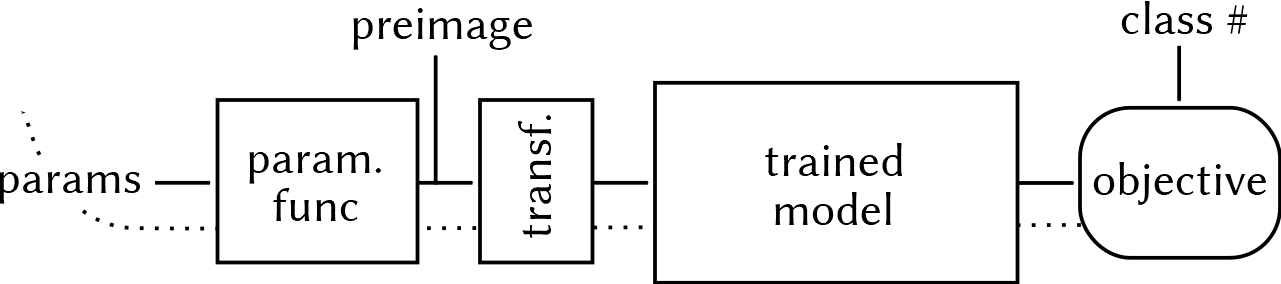

#### Parametrization

Firstly, we do not have to optimize the image directly: we can instead optimize some parametrization of the image if we have some differentiable generator at our disposal: it is denoted with `"param. func"` in the figure.

This generator can be as simple as the (inverse) fast Fourier transform (inverse **FFT** ; actually, when applying this, you also scale frequencies so that they all have the same energy), or as complicated as an adversarial generative network: (**GAN** ). It can also include other differentiable operations such as **colour decorrelation** .

#### Transforms

The image can also undergo some further transforms before it is passed to our deep network. The `lucent` package uses the following transforms by default:

```
standard_transforms = [
    pad(12, mode="constant", constant_value=0.5),
    jitter(8),
    random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
    random_rotate(list(range(-10, 11)) + 5 * [0]),
    jitter(4),
]
```
The interesting ones are especially:

* **Jitter** , which randomly translates the image by a certain number of pixels (the parameter to `jitter` is the maximum number of pixels);
* **Random scale** , which scales the image randomly;
* **Random rotate** , which rotates it.
This additional noise regularizes the optimization process and makes the resulting images crisper.

#### Additional Objectives

A further way to regularize is to add more components to the activation maximization objective. Examples may include:

* **$L^p$ norm** : penalizes for the size of the image vector. This can help keep pixel values within reasonable ranges [[inverting](#inverting)]. Here we are using the following definition:
$$
|| \textbf{x} - \text{ref} ||*p = \left(\sum* {i} |x_i - \text{ref} |^p \right)^\frac{1}{p},
$$
where $\mathbf{ref} = 0.5$ is a reference value. Note that our pixels are represented by floats in the $[0, 1]$ range so by setting $\text{ref} = 0.5$ the $L^p$ norm is pulling them towards the middle value of $0.5$. Also, in keeping with [[inverting](#inverting)], we use $p=6$.


* **Total variation**  (TV): penalizes variation by adding up Euclidean distances between neighbouring pixels. Makes images smoother. For image $\mathbf{x}$, the TV is defined as [[inverting](#inverting)]:
$$
TV^{\beta}(\mathbf{x}) = \sum*{i,j} \left(
  \left( x* {i,j+1} - x*{ij} \right)^2 +
  \left( x* {i+1,j} - x_{ij} \right)^2
\right)^{\frac{\beta}{2}},
$$
where $\beta$ is a hyperparameter; we will be using $\beta = 2$. For multi-channel images, the TV is computed separately for each channel and the results are summed up.


### Example: Regularizing the Ostrich Preimages

Now that we know about all these tricks, let us apply some of them to our ostrich preimage and see whether the results get any better.

#### Transforms

Let us start by using the default set of transformations (we only need to remove the `transforms=[]` parameter).



In [ ]:
obj = objectives.channel("labels", 9)
batch_param_f = lambda: param.image(224, batch=4, fft=False, decorrelate=False)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

Well, that is definitely an improvement: we can see patterns that vaguely resemble ostrich bodies, their long necks and heads. But they are not very distinct and the colours are wrong.

#### FFT and Colour Decorrelation

Let us try to change the parametrization next and use the FFT and colour decorrelation. Again, these are on by default, so we just drop the parameters.



In [ ]:
obj = objectives.channel("labels", 9)
batch_param_f = lambda: param.image(224, batch=4)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

#### Additional Objectives

Finally, let us add the LP norm and the TV loss to keep the colours less extreme and to smoothen the image out a little bit. Each objective will have a different weight: these were tuned experimentally.



In [ ]:
batch_param_f = lambda: param.image(224, batch=4)
obj = objectives.channel("labels", 9) + 500 * tv_objective() + 5*lp_objective(ref=0.5)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

### Other Classes

Now that we can produce preimages that actually show some patterns, let us examine some other classes. Neuron 949 corresponds to strawberries:



In [ ]:
obj = objectives.channel("labels", 949) + (500 * tv_objective() + 5*lp_objective(ref=0.5))
batch_param_f = lambda: param.image(224, batch=4)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

What would bees (309) look like?



In [ ]:
obj = objectives.channel("labels", 309) + (500 * tv_objective() + 5*lp_objective(ref=0.5))
batch_param_f = lambda: param.image(224, batch=4)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

---
#### Task 1: Experiment with More Classes

**Try to visualize preimages for some more classes.** 

Note: for reference, you can display the list of all the 1000 ImageNet classes using:

```
for ic, c in enumerate(class_names):
    print('{}: {}; '.format(ic, c))
```
---


### Using a GAN Parametrization

To get even more natural-looking images, we can use a GAN parametrization. That way we will be optimizing the input of a GAN network, which has already been trained to generate natural images and so it should have a much better idea of what they should look like. Our deep classifier will, in a sense, act as a guide to the GAN network: criticizing its output and telling it what to change in order to maximize the activation of the target neuron.

For the ostrich example:



In [ ]:
obj = objectives.channel("labels", 9)
batch_param_f = lambda: GANparam(batch=4)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

For the strawberry example:



In [ ]:
obj = objectives.channel("labels", 949)
batch_param_f = lambda: GANparam(batch=4)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

For the bee example:



In [ ]:
obj = objectives.channel("labels", 309)
batch_param_f = lambda: GANparam(batch=4)
imgs = render_vis(model, obj, batch_param_f, show_inline=False)[0]
fig = show_images(imgs)

---
#### Task 2: Experiment with More Classes

**Try to visualize preimages for some more classes using the GAN parametrization.** 

Note: for reference, you can display the list of all the 1000 ImageNet classes using:

```
for ic, c in enumerate(class_names):
    print('{}: {}; '.format(ic, c))
```
---


<a id="preimages">[preimages]</a> Mahendran, A. and Vedaldi, A., 2016. Visualizing deep convolutional neural networks using natural pre-images. International Journal of Computer Vision, 120(3), pp.233-255.

<a id="inverting">[inverting]</a> Mahendran, A. and Vedaldi, A., 2015. Understanding deep image representations by inverting them. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 5188-5196).

